In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo

In [4]:
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/RAVAR_GWASCat/'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

## Load EFO Ontology

In [34]:
efo = obo.read_obo('http://www.ebi.ac.uk/efo/efo.obo')
efo_root='EFO:0000001'

In [35]:
n = list(efo.nodes())

In [6]:
depths = nx.single_target_shortest_path_length(efo, efo_root)
depth_dict = {source:distance for source, distance in depths}

In [1]:
def return_more_specific_code(codeA, codeB, depth_dict, study_data):
    if codeA == codeB:
        return codeA
    try:
        codeA, codeB = [code.replace('_', ':') for code in [codeA, codeB]]
    except:
        if type(codeA) == float:
            return codeB
        elif type(codeB) == float:
            return codeA
        else:
            print('TYPE_ERROR:', codeA, codeB)
    present = [code in depth_dict for code in [codeA, codeB]]
    if sum(present) == 2:

        depthA = depth_dict[codeA]
        depthB = depth_dict[codeB]
        if depthA > depthB:
            return codeA
        elif depthB > depthA:
            return codeB
        # if they have the same depth, return the one with fewer studies listed. 
        else:
            return check_study_counts(codeA, codeB, study_data)
    elif sum(present) == 1:
        return [codeA, codeB][present.index(True)]
    else:
        print(f'Neither {codeA} or {codeB} present in EFO. Returning {codeB}')
        return codeB
    
def check_study_counts(codeA, codeB, data):
    codeA, codeB = [code.replace(':', '_') for code in [codeA, codeB]]
    codeA_count = data[data.STUDY_EFO==codeA].shape[0] + data[data.TRAIT_EFO==codeA].shape[0]
    codeB_count = data[data.STUDY_EFO==codeB].shape[0] + data[data.TRAIT_EFO==codeB].shape[0]
    if codeA_count < codeB_count:
        return codeA
    if codeB_count < codeA_count:
        return codeB
    elif codeB_count == codeA_count:
        print(f'{codeA} and {codeB} have equal study counts. Returning {codeB}')
        return manually_determine_correct_code(codeA, codeB, data)

def manually_determine_correct_code(codeA, codeB, data):
    sub_data = data[(data.STUDY_EFO==codeA) & (data.TRAIT_EFO==codeB)]
    for col in ['DISEASE/TRAIT', 'MAPPED_TRAIT', 'STUDY_EFO', 'Disease trait', 'EFO term', 'TRAIT_EFO']:
        print(f'{col}:', sub_data[col].values)
    return input()
    

## Load raw data

### RAVAR

In [36]:
ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt'),sep='\t', 
                            usecols=['Gene Symbol', 'Ensembl ID', 'Gene Type', 'CHR', 'Location', 'Reported Trait', 'Trait Label', 'Trait Ontology id', 'EFO synonym', 'P-value', 'PMID'])
#replace '−' with '-'
ravar_genes['P-value'] = ravar_genes['P-value'].apply(lambda x: float(x.replace('−','-')) if type(x) == str else float(x))
ravar_genes['TRAIT_CODE'] = ravar_genes['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)

/tmp/ipykernel_687938/288862769.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt'),sep='\t',


In [37]:
print('Reported traits', len(ravar_genes['Reported Trait'].unique()))
print('Total traits with Ontology', len(ravar_genes['Trait Ontology id'].unique()))
print('Total genes', len(ravar_genes['Gene Symbol'].unique()))
print('Unique studies', len(ravar_genes['PMID'].unique()))
print('Min p-value', ravar_genes['P-value'].min())
print('Max p-value', ravar_genes['P-value'].max())

Reported traits 3049
Total traits with Ontology 1468
Total genes 12850
Unique studies 200
Min p-value 0.0
Max p-value 9.94e-05


RAVAR seems to have better EFO matching. No further work needed

Score distributions
* Minimum reported is 10-4. I am already using this as a threshold.
* Do they link to sum stats

In [38]:
ravar_genes['logp'] = -1 * np.log10(ravar_genes['P-value'] + 1e-250)

(0.5, 100000)

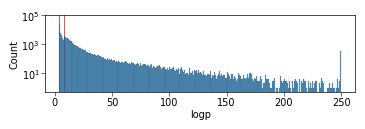

In [39]:
_  = plt.figure(figsize=(4, 1))
sns.histplot(ravar_genes.logp, bins=300)
plt.yscale('log')
plt.vlines(x=4,ymin=0.5, ymax=1000000, color='red', zorder= 0, linewidth=0.5)
plt.vlines(x=8,ymin=0.5, ymax=1000000, color='red', zorder= 0, linewidth=0.5)
plt.ylim(0.5, 100000)

### GWAS Catalog

In [7]:
def clean_gwas_catalog_data(datafile, outfile, pval_th=5e-8, include_intergenic=False):
    """Clean the GWAS Catalog data and write to a new file.

    Args:
        datafile (str): file path for GWAS Catalog data
        outfile (str): output file for cleaned data
        pval_th (float): p-value threshold for filtering
        include_intergenic (bool): whether to include intergenic associations

    Returns:
        None
    """
    cols= ['DATE', 'PUBMEDID', 'DISEASE/TRAIT', 'MAPPED_GENE', 'SNP_GENE_IDS', 'P-VALUE', 'OR or BETA' ,'MAPPED_TRAIT', 
           'MAPPED_TRAIT_URI', 'INTERGENIC', 'STUDY ACCESSION', 'SNP_ID_CURRENT', 'INITIAL SAMPLE SIZE', 'GENOTYPING TECHNOLOGY']    
    if include_intergenic:
        cols = cols + ['UPSTREAM_GENE_ID', 'DOWNSTREAM_GENE_ID', 'UPSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_DISTANCE']
    data = pd.read_csv(datafile, sep="\t", usecols=cols)
    # filter on pval
    data = data[data["P-VALUE"] <= pval_th]
    # filter on gene and trait present
    data = data.dropna(subset=['SNP_GENE_IDS', "MAPPED_TRAIT_URI"])
    # filter out intergenic
    if not include_intergenic:
        data = data[data["INTERGENIC"] == 0]
    # remove associations with multiple genes
    data = data[~data["SNP_GENE_IDS"].str.contains(",")]
    # remove associations with multiple traits
    data = data[~data["MAPPED_TRAIT_URI"].str.contains(",")]
    # create trait code
    data['TRAIT_CODE'] = data['MAPPED_TRAIT_URI'].apply(lambda x: x.split('/')[-1])
    # write the cleaned file
    data.to_csv(outfile, sep="\t", index=False)

In [8]:
clean_gwas_catalog_data(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt'), os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedMar28'), pval_th=1)

/tmp/ipykernel_3332976/2161290776.py:17: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile, sep="\t", usecols=cols)


In [41]:
gwas_genes= pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29'), sep="\t")
gwas_genes_old = pd.read_csv(os.path.join(datadir, 'GWASCatalog/Jan22', 'gwas_cat_download_Jan22.txt.cleanedJun17'), sep="\t")

In [42]:
gwas_genes[gwas_genes['STUDY ACCESSION']=='GCST001220']

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE
31074,21931564,2011-09-08,Metabolite levels,PYROXD2,ENSG00000119943,0.0,8.000000e-15,1.19,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725
31075,21931564,2011-09-08,Metabolite levels,AGXT2,ENSG00000113492,0.0,1.000000e-06,1.25,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725
31076,21931564,2011-09-08,Metabolite levels,ALMS1,ENSG00000116127,0.0,1.000000e-11,1.10,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725


In [43]:
print('Total reported traits', len(gwas_genes_old['DISEASE/TRAIT'].unique()))
print('Total traits with ontology', len(gwas_genes_old['TRAIT_CODE'].unique()))
print('Total genes', len(gwas_genes_old['MAPPED_GENE'].unique()))
print('Min p-value', gwas_genes_old['P-VALUE'].min())
print('Max p-value', gwas_genes_old['P-VALUE'].max())

Total reported traits 18955
Total traits with ontology 6863
Total genes 16052
Min p-value 0.0
Max p-value 1e-05


In [44]:
print('Total reported traits', len(gwas_genes['DISEASE/TRAIT'].unique()))
print('Total traits with ontology', len(gwas_genes['TRAIT_CODE'].unique()))
print('Total genes', len(gwas_genes['MAPPED_GENE'].unique()))
print('Min p-value', gwas_genes['P-VALUE'].min())
print('Max p-value', gwas_genes['P-VALUE'].max())

Total reported traits 24893
Total traits with ontology 7351
Total genes 17133
Min p-value 0.0
Max p-value 1e-05


Score distributions

In [45]:
gwas_genes['logp'] = -1 * np.log10(gwas_genes['P-VALUE']+1e-300)

In [46]:
gwas_genes['logp'].describe()

count    336840.000000
mean         22.148681
std          40.167155
min           5.000000
25%           8.000000
50%          10.698970
75%          18.000000
max         300.000000
Name: logp, dtype: float64

(0.5, 100000)

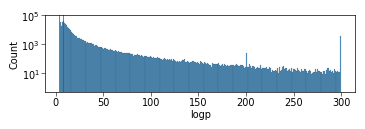

In [47]:
_  = plt.figure(figsize=(4, 1))
sns.histplot(gwas_genes.logp, bins=300)
plt.yscale('log')
plt.vlines(x=4,ymin=0.5, ymax=1000000, color='red', zorder= 0, linewidth=0.5)
plt.vlines(x=8,ymin=0.5, ymax=1000000, color='red', zorder= 0, linewidth=0.5)
plt.ylim(0.5, 100000)

In [56]:
gwas_genes.head()

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,MAPPED_TRAIT,MAPPED_TRAIT_URI,TRAIT_CODE,logp
0,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,23.221849
1,23583979,2013-04-14,Heart rate,MYH6,ENSG00000197616,0.0,5.000000e-45,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,44.301030
2,23583979,2013-04-14,Heart rate,KIAA1755,ENSG00000149633,0.0,5.000000e-29,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,28.301030
3,23583979,2013-04-14,Heart rate,CCDC141,ENSG00000163492,0.0,4.000000e-26,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,25.397940
4,23583979,2013-04-14,Heart rate,CHRM2,ENSG00000181072,0.0,1.000000e-12,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,12.000000


### GWAS Catalog Study info

In [6]:
def return_more_specific_code(codeA, codeB, depth_dict, study_data):
    # are the codes the same?
    if codeA == codeB:
        return codeA
    # is it just a formatting issue?
    try:
        codeA, codeB = [code.replace('_', ':') for code in [codeA, codeB]]
    except:
        # is one not an EFO code?
        if type(codeA) == float:
            return codeB
        elif type(codeB) == float:
            return codeA
        else:
            print('TYPE_ERROR:', codeA, codeB)
    
    present = [code in depth_dict for code in [codeA, codeB]]
    if sum(present) == 2:
        depthA = depth_dict[codeA]
        depthB = depth_dict[codeB]
        if depthA > depthB:
            return codeA
        elif depthB > depthA:
            return codeB
        else:
            return check_study_counts(codeA, codeB, study_data)
    # return the code that is present
    elif sum(present) == 1:
        return [codeA, codeB][present.index(True)]
    # manually determine the better code
    else:
        print(f'Neither {codeA} or {codeB} present in EFO. Returning {codeB}')
        return codeB
    
def check_study_counts(codeA, codeB, data):
    codeA, codeB = [code.replace(':', '_') for code in [codeA, codeB]]
    codeA_count = data[data.STUDY_EFO==codeA].shape[0] + data[data.TRAIT_EFO==codeA].shape[0]
    codeB_count = data[data.STUDY_EFO==codeB].shape[0] + data[data.TRAIT_EFO==codeB].shape[0]
    if codeA_count < codeB_count:
        return codeA
    if codeB_count < codeA_count:
        return codeB
    elif codeB_count == codeA_count:
        print(f'{codeA} and {codeB} have equal study counts. Returning {codeB}')
        return manually_determine_correct_code(codeA, codeB, data)

def manually_determine_correct_code(codeA, codeB, data):
    sub_data = data[(data.STUDY_EFO==codeA) & (data.TRAIT_EFO==codeB)]
    for col in ['DISEASE/TRAIT', 'MAPPED_TRAIT', 'STUDY_EFO', 'Disease trait', 'EFO term', 'TRAIT_EFO']:
        print(f'{col}:', sub_data[col].values)
    return input()
    

In [7]:
if False:
    gwas_study = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'study_info.v1.0.3.1_Jan29_2025.txt'), sep="\t", 
                            usecols=['DISEASE/TRAIT','ASSOCIATION COUNT','MAPPED_TRAIT', 'MAPPED_TRAIT_URI','STUDY ACCESSION',
                            'BACKGROUND TRAIT', 'MAPPED BACKGROUND TRAIT', 'MAPPED BACKGROUND TRAIT URI','COHORT', 
                            'FULL SUMMARY STATISTICS', 'SUMMARY STATS LOCATION', 'DATE ADDED TO CATALOG', 'INITIAL SAMPLE SIZE',
                            'GENOTYPING TECHNOLOGY'  ])
    trait_mappings = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'trait_mappings.txt'), sep="\t", usecols=['Disease trait', 'EFO term', 'EFO URI'])
    trait_mappings['TRAIT_EFO'] = trait_mappings['EFO URI'].apply(lambda x: x.split('/')[-1])
    trait_mappings.drop(columns=['EFO URI'], inplace=True)
    #gwas_study = gwas_study.loc[(gwas_study['MAPPED BACKGROUND TRAIT URI'].isna()) & (gwas_study['FULL SUMMARY STATISTICS'] == 'yes')]
    gwas_study = gwas_study.loc[~gwas_study['MAPPED_TRAIT_URI'].isna()]
    gwas_study = gwas_study.loc[~gwas_study["MAPPED_TRAIT_URI"].str.contains(",")]
    gwas_study['STUDY_EFO'] = gwas_study['MAPPED_TRAIT_URI'].apply(lambda x: x.split('/')[-1])
    gwas_study['GENOTYPING TECHNOLOGY'] = gwas_study['GENOTYPING TECHNOLOGY'].apply(lambda x: x.split('[')[0].strip())
    # problem is here where there can be more than one match in the trait mappings. What
    # was the problem I was trying to solve? 
    gwas_study = gwas_study.merge(trait_mappings, left_on='DISEASE/TRAIT', right_on='Disease trait', how='left')
    gwas_study['TRAIT_CODE'] = gwas_study.apply(lambda x: return_more_specific_code(x['STUDY_EFO'], x['TRAIT_EFO'], depth_dict, gwas_study), axis=1)
    gwas_study.loc[:, ('DISEASE/TRAIT', 'ASSOCIATION COUNT', 'STUDY ACCESSION','COHORT','MAPPED BACKGROUND TRAIT URI', 
                       'SUMMARY STATS LOCATION','TRAIT_CODE', 'DATE ADDED TO CATALOG', 'INITIAL SAMPLE SIZE', 'GENOTYPING TECHNOLOGY')].to_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned_Jan29_2025.txt'), sep='\t', index=False)
else:
    gwas_study = pd.read_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned_Jan29_2025.txt'), sep='\t')

In [49]:
gwas_genes[gwas_genes['STUDY ACCESSION'] == 'GCST001220']

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE,logp
31074,21931564,2011-09-08,Metabolite levels,PYROXD2,ENSG00000119943,0.0,8.000000e-15,1.19,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725,14.09691
31075,21931564,2011-09-08,Metabolite levels,AGXT2,ENSG00000113492,0.0,1.000000e-06,1.25,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725,6.00000
31076,21931564,2011-09-08,Metabolite levels,ALMS1,ENSG00000116127,0.0,1.000000e-11,1.10,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725,11.00000


In [50]:
trait_mappings['Disease trait'].value_counts().sort_values(ascending=False)

Disease trait
Metabolite levels                                   233
Obesity-related traits                               66
Blood protein levels                                 56
Blood protein levels in cardiovascular risk          55
Cardiometabolic traits                               53
                                                   ... 
Cutaneous squamous cell carcinoma                     1
Zinc finger protein 10 levels                         1
Zinc finger protein 10 levels (ZNF10.11567.23.3)      1
Small intestine neuroendocrine tumor                  1
Cognitive test performance                            1
Name: count, Length: 53933, dtype: int64

In [28]:
gwas_genes[gwas_genes['MAPPED_TRAIT_URI']=='http://www.ebi.ac.uk/efo/EFO_0007813']

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE
32129,23823483,2013-07-02,Metabolite levels,CNTNAP2,ENSG00000174469,0.0,1.000000e-06,0.182363,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813,GCST009391,EFO_0007813
32130,23823483,2013-07-02,Metabolite levels,CDH4,ENSG00000179242,0.0,1.000000e-06,0.697002,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813,GCST009391,EFO_0007813
32131,23823483,2013-07-02,Metabolite levels,CTNNA2,ENSG00000066032,0.0,4.000000e-06,0.207161,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813,GCST009391,EFO_0007813
113339,29631575,2018-04-10,Cotinine levels in smokers with chronic obstru...,HYKK,ENSG00000188266,0.0,3.000000e-07,0.120000,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813,GCST005916,EFO_0007813


In [51]:
trait_mappings = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'trait_mappings.txt'), sep="\t", usecols=['Disease trait', 'EFO term', 'EFO URI'])
trait_mappings[trait_mappings['Disease trait']=='Metabolite levels']

,Disease trait,EFO term,EFO URI
765,Metabolite levels,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813
1656,Metabolite levels,symmetrical dimethylarginine measurement,http://www.ebi.ac.uk/efo/EFO_0006523
1664,Metabolite levels,L-arginine measurement,http://www.ebi.ac.uk/efo/EFO_0006524
5262,Metabolite levels,plasma betaine measurement,http://www.ebi.ac.uk/efo/EFO_0007787
5355,Metabolite levels,thyroxine measurement,http://www.ebi.ac.uk/efo/EFO_0005130
...,...,...,...
47923,Metabolite levels,valine measurement,http://www.ebi.ac.uk/efo/EFO_0009792
49240,Metabolite levels,serotonin measurement,http://www.ebi.ac.uk/efo/EFO_0004846
52720,Metabolite levels,triiodothyronine measurement,http://www.ebi.ac.uk/efo/EFO_0008392
56815,Metabolite levels,kynurenine measurement,http://www.ebi.ac.uk/efo/EFO_0008529


In [19]:
gwas_study[gwas_study['STUDY ACCESSION'] =='GCST001220']

,DISEASE/TRAIT,ASSOCIATION COUNT,STUDY ACCESSION,COHORT,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE,DATE ADDED TO CATALOG,INITIAL SAMPLE SIZE
4895,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO_0007813,2012-02-10,142 European ancestry female twins
4896,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0006523,2012-02-10,142 European ancestry female twins
4897,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0006524,2012-02-10,142 European ancestry female twins
4898,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0007787,2012-02-10,142 European ancestry female twins
4899,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0005130,2012-02-10,142 European ancestry female twins
...,...,...,...,...,...,...,...,...,...
5123,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0009792,2012-02-10,142 European ancestry female twins
5124,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0004846,2012-02-10,142 European ancestry female twins
5125,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO_0008392,2012-02-10,142 European ancestry female twins
5126,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0008529,2012-02-10,142 European ancestry female twins


Restrict to those with at least one association

In [52]:
gwas_study = gwas_study.loc[gwas_study['ASSOCIATION COUNT'] >= 1]
gwas_study.shape

(57469, 9)

In [53]:
gwas_study.TRAIT_CODE.nunique()

11315

Identify common traits not in the overlap set

In [59]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_Jun27.txt'), 'r') as f:
    overlap_traits = [x.strip() for x in f.readlines()]

In [61]:
len(overlap_traits)

552

In [90]:
# keep those not in overlap
testing_studies = [t for t in gwas_study[~gwas_study['SUMMARY STATS LOCATION'].isna()].TRAIT_CODE.unique() if (t not in overlap_traits) and (t.replace('_', ':') not in overlap_traits)]

In [91]:
# keep those with summary statistics
testing_study = gwas_study[gwas_study.TRAIT_CODE.isin(testing_studies) & ~gwas_study['SUMMARY STATS LOCATION'].isna()]

In [92]:
# keep those with no background trait
testing_study = testing_study[testing_study['MAPPED BACKGROUND TRAIT URI'].isna()]

In [93]:
# keep those with at least one association
testing_study = testing_study[testing_study['ASSOCIATION COUNT'] > 0]

In [94]:
# look at the distribution of associations
testing_study['ASSOCIATION COUNT'].describe(percentiles=[0.75,0.8,0.85, 0.9, 0.95, 0.99])

count    18853.000000
mean        12.481197
std         57.574850
min          1.000000
50%          2.000000
75%          4.000000
80%          6.000000
85%          9.000000
90%         15.000000
95%         47.000000
99%        200.000000
max       2008.000000
Name: ASSOCIATION COUNT, dtype: float64

In [95]:
testing_study = testing_study[testing_study['ASSOCIATION COUNT'] >= 5]

In [118]:
# map traits to EFO categories?
global_map = assign_trait_list_to_global(list(testing_study.TRAIT_CODE.unique()), efo)
# map disease categories
disease_map = assign_trait_list_to_global(global_map['EFO:0000408'],efo , [node for node in efo.predecessors( 'EFO:0000408')] )
# map measurement categories
measure_map = assign_trait_list_to_global(global_map['EFO:0001444'],efo, [node for node in efo.predecessors( 'EFO:0001444')] )
# map abnormality categories
abnorm_map = assign_trait_list_to_global(global_map['HP:0000118'],efo, [node for node in efo.predecessors( 'HP:0000118')] )

EFO:0003761 not in efo graph


In [139]:
import random as rn
def select_random_traits(trait_map):
    traits = []
    for k in trait_map.keys():
        n = len(trait_map[k])
        if n == 0:
            pass
        elif n == 1:
            traits += trait_map[k]
        else:
            n_select = min(1, int(n*0.1))
            traits += rn.sample(trait_map[k], n_select)
    return set(traits)
disease_traits = select_random_traits(disease_map)
measurement_traits = select_random_traits(measure_map)
abnorm_traits = select_random_traits(abnorm_map)
all_test_traits = disease_traits.union(measurement_traits).union(abnorm_traits)

In [141]:
all_test_traits =[x.replace(':', '_') for x in list(all_test_traits)]

In [142]:
testing_study['Trait'] = testing_study.TRAIT_CODE.apply(lambda x: x.replace(':', '_'))

In [152]:
exclude = list(testing_df.Trait.value_counts()[(testing_df.Trait.value_counts() >= 10)].index)

In [154]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_gwas_traits_Dec3.txt'), 'w') as f:
    for trait in all_test_traits:
        if trait not in exclude:
            f.write(trait + '\n')

In [166]:
testing_df = testing_study[testing_study.Trait.isin(all_test_traits) & ~testing_study.Trait.isin(exclude)].drop_duplicates()

In [167]:
testing_df

,DISEASE/TRAIT,ASSOCIATION COUNT,STUDY ACCESSION,COHORT,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE,Trait
312,Ischemic stroke (cardioembolic),10,GCST005842,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO:1001976,EFO_1001976
313,Ischemic stroke (cardioembolic),10,GCST005842,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_1001976,EFO_1001976
318,Ischemic stroke (cardioembolic),5,GCST006910,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO:1001976,EFO_1001976
319,Ischemic stroke (cardioembolic),5,GCST006910,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_1001976,EFO_1001976
443,Smoking behaviour (cigarettes smoked per day),8,GCST007602,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0006525,EFO_0006525
...,...,...,...,...,...,...,...,...
114812,Mitochondrial DNA heteroplasmy (chrM:302:A:AC ...,20,GCST90268467,UKB,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0600008,EFO_0600008
114821,Mitochondrial DNA heteroplasmy (chrM:302:A:ACC...,8,GCST90268476,UKB,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0600008,EFO_0600008
114827,Mitochondrial DNA heteroplasmy (chrM:16183:AC:...,6,GCST90268482,UKB,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0600008,EFO_0600008
114828,Mitochondrial DNA heteroplasmy (chrM:16183:A:A...,5,GCST90268483,UKB,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0600008,EFO_0600008


In [170]:
print(testing_df[testing_df.Trait=='EFO_1001976']['SUMMARY STATS LOCATION'].values)

['http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST005001-GCST006000/GCST005842'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST005001-GCST006000/GCST005842'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST006001-GCST007000/GCST006910'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST006001-GCST007000/GCST006910'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST90104001-GCST90105000/GCST90104541'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST90104001-GCST90105000/GCST90104536']


In [172]:
urls = list(testing_df['SUMMARY STATS LOCATION'].unique())

In [180]:
testing_df.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_study_info_Dec3.txt', sep='\t')

In [175]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_gwas_sumstats_urls.txt'), 'w') as f:
    for url in urls:
        f.write(url + '\n')

In [177]:
len(urls)

136

## Subset to genes in both before further filtering of trait codes. Need to remove those that are too broad

#### Convert identifiers

RAVAR

In [54]:
if False:
    ensembl_map, missing = qe.get_latest_ensembl_id(ravar_genes['Ensembl ID'].unique())
    ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
    ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]
    id_ensembl = ravar_genes.merge(ensembl_map.loc[:, ('from', 'Entrez')], left_on='Ensembl ID', right_on='from', how='inner')
    id_ensembl = id_ensembl[id_ensembl['Entrez'] != '']
    symbol_map, symbol_missing = qh.perform_hgnc_query(id_ensembl[(id_ensembl['Entrez'].isnull()) | (id_ensembl['Entrez']== '')]['Gene Symbol'].unique(), 'Symbol', 'Symbol')
    symbol_to_entrez, missing = gm.convert_node_ids(list(symbol_map.values()), 'Symbol', 'Entrez')
    symbol_map = pd.DataFrame(symbol_map.items(), columns=['from', 'to'])
    symbol_map['Entrez'] = [symbol_to_entrez[x] if x in symbol_to_entrez else '' for x in symbol_map['to']]
    id_symbol = ravar_genes.iloc[~id_ensembl.index].merge(symbol_map.loc[:, ('from', 'Entrez')], left_on='Gene Symbol', right_on='from', how='inner')
    converted_ravar_genes = pd.concat([id_ensembl, id_symbol])
    converted_ravar_genes.to_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'), sep='\t', index=False)
else:
    converted_ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'), sep='\t')

In [55]:
ravar_genes.head()

,Gene Symbol,Ensembl ID,Gene Type,CHR,Location,Reported Trait,Trait Label,Trait Ontology id,EFO synonym,P-value,PMID,TRAIT_CODE,logp
0,A1BG,ENSG00000121410,protein_coding,19,chr19:58345178-58353492,Abnormal findings on diagnostic imaging of oth...,abnormal result of diagnostic imaging,EFO:0009827,NaN,5.910000e-05,34375979,EFO_0009827,4.228413
1,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Total Protein measurement,total blood protein measurement,EFO:0004536,serum total protein;TBP,5.000000e-09,34226706,EFO_0004536,8.301030
2,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Calcium measurement,calcium measurement,EFO:0004838,calcium levels,2.100000e-08,34226706,EFO_0004838,7.677781
3,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry SHBG measurement,sex hormone-binding globulin measurement,EFO:0004696,SHBG levels;SHBG level,1.000000e-06,34226706,EFO_0004696,6.000000
4,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Gamma Glutamyl transferase measur...,serum gamma-glutamyl transferase measurement,EFO:0004532,GGT measurement;Gamma gluatamyl transferase le...,1.400000e-19,34226706,EFO_0004532,18.853872


In [56]:
# add the PMCIDs to the converted data
converted_ravar_genes = converted_ravar_genes.merge(ravar_genes.loc[:, ('PMID', 'Ensembl ID', 'Trait Label', 'P-value', 'Reported Trait', 'Location',
                        'Gene Symbol')].drop_duplicates(), on=['Gene Symbol', 'Ensembl ID', 'Trait Label', 'P-value', 'Reported Trait', 'Location'], how='left')

In [57]:
converted_ravar_genes.shape

(76468, 15)

GWAS Cat

In [5]:
if False:
    ensembl_map, missing = qe.get_latest_ensembl_id(gwas_genes['SNP_GENE_IDS'].unique())
    ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
    ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]
    id_ensembl = gwas_genes.merge(ensembl_map.loc[:, ('from', 'Entrez')], left_on='SNP_GENE_IDS', right_on='from', how='left')
    symbol_map, symbol_missing = qh.perform_hgnc_query(id_ensembl[(id_ensembl['Entrez'].isnull()) | (id_ensembl['Entrez']== '')]['MAPPED_GENE'].unique(), 'Symbol', 'Symbol')
    symbol_to_entrez, missing = gm.convert_node_ids(list(symbol_map.values()), 'Symbol', 'Entrez')
    symbol_map = pd.DataFrame(symbol_map.items(), columns=['from', 'to'])
    symbol_map['Entrez'] = [symbol_to_entrez[x] if x in symbol_to_entrez else '' for x in symbol_map['to']]
    id_symbol = gwas_genes.iloc[~id_ensembl.index].merge(symbol_map.loc[:, ('from', 'Entrez')], left_on='MAPPED_GENE', right_on='from', how='inner')
    id_ensembl = id_ensembl[(id_ensembl['Entrez'] != '') & (~id_ensembl['Entrez'].isnull())]
    converted_gwas_genes = pd.concat([id_ensembl, id_symbol])
    converted_gwas_genes = converted_gwas_genes[converted_gwas_genes['Entrez'] != '']
    converted_gwas_genes.to_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29.entrez'), sep="\t", index=False)
else:
    converted_gwas_genes = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29.entrez'), sep="\t")

Genes in both data sets

In [6]:
print('Shared ensembl IDs:', len(set(ravar_genes['Ensembl ID']).intersection(set(gwas_genes['SNP_GENE_IDS']))))
print('Shared gene symbols:', len(set(ravar_genes['Gene Symbol']).intersection(set(gwas_genes['MAPPED_GENE']))))
print('Shared Entrez Gene IDs:', len(set(converted_ravar_genes['Entrez']).intersection(set(converted_gwas_genes['Entrez']))))

NameError: name 'ravar_genes' is not defined

Map updated EFO traits for GWASCat

In [60]:
converted_gwas_genes = converted_gwas_genes.drop(columns=['TRAIT_CODE', 'MAPPED_TRAIT_URI']).merge(gwas_study.drop(columns=['COHORT', 'ASSOCIATION COUNT', 'SUMMARY STATS LOCATION' ]), on=['STUDY ACCESSION', "DISEASE/TRAIT"])

In [61]:
gwas_genes = gwas_genes.drop(columns=['TRAIT_CODE']).merge(gwas_study.drop(columns=['COHORT', 'ASSOCIATION COUNT']), on=["STUDY ACCESSION","DISEASE/TRAIT"])

## Data descriptions

Distribution of p-values

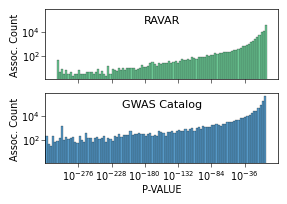

In [62]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(3, 2), sharex=True, sharey=True)
sns.histplot(ravar_genes['P-value'], bins=100, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes['P-VALUE'], bins=100, log_scale=True, ax=ax2)

plt.yscale('log')
ax1.set_ylabel('Assoc. Count')
ax2.set_ylabel('Assoc. Count')
ax1.annotate('RAVAR', xy=(0.5, 0.8), xycoords='axes fraction', ha='center', fontsize=8)
ax2.annotate('GWAS Catalog', xy=(0.5, 0.8), xycoords='axes fraction', ha='center', fontsize=8)
plt.savefig(os.path.join(figdir, 'pvalue_dists.png'), dpi=300, bbox_inches='tight')

Distribution of genes/trait

In [77]:
rv_genes_per_trait = ravar_genes.groupby('Trait Ontology id')['Gene Symbol'].nunique()

In [38]:
gwas_genes.head()

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION_x,logp,STUDY ACCESSION_y,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE
0,25673412,2015-02-12,Hip circumference adjusted for BMI,TSEN15,ENSG00000198860,0.0,6.000000e-10,0.0232,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,9.221849,GCST004067,NaN,NaN,EFO_0008039
1,25673412,2015-02-12,Hip circumference adjusted for BMI,TSEN15,ENSG00000198860,0.0,6.000000e-10,0.0232,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,9.221849,GCST008156,NaN,NaN,EFO_0008039
2,25673412,2015-02-12,Hip circumference adjusted for BMI,TSEN15,ENSG00000198860,0.0,6.000000e-10,0.0232,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,9.221849,GCST90086165,NaN,NaN,EFO_0008039
3,25673412,2015-02-12,Hip circumference adjusted for BMI,TSEN15,ENSG00000198860,0.0,6.000000e-10,0.0232,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,9.221849,GCST90086167,NaN,NaN,EFO_0008039
4,25673412,2015-02-12,Hip circumference adjusted for BMI,TSEN15,ENSG00000198860,0.0,6.000000e-10,0.0232,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,9.221849,GCST90020028,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0008039


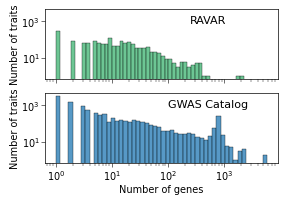

In [78]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(3, 2), sharex=True, sharey=True)
sns.histplot(ravar_genes.groupby('Trait Ontology id')['Gene Symbol'].nunique(), bins=50, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes.groupby('TRAIT_CODE')['MAPPED_GENE'].nunique(), bins=50, log_scale=True, ax=ax2)
plt.yscale('log')
plt.xlabel('Number of genes')
ax1.set_ylabel('Number of traits')
ax2.set_ylabel('Number of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=8)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=8)
plt.savefig(os.path.join(figdir, 'n_gene_dists.png'), dpi=300, bbox_inches='tight')

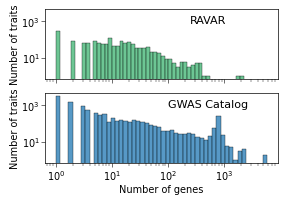

In [79]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(3, 2), sharex=True, sharey=True)
sns.histplot(ravar_genes.groupby('Trait Ontology id')['Gene Symbol'].nunique(), bins=50, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes.groupby('TRAIT_CODE')['MAPPED_GENE'].nunique(), bins=50, log_scale=True, ax=ax2)
plt.yscale('log')
plt.xlabel('Number of genes')
ax1.set_ylabel('Number of traits')
ax2.set_ylabel('Number of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=8)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=8)
plt.savefig(os.path.join(figdir, 'n_gene_dists.png'), dpi=300, bbox_inches='tight')

Text(0.7, 0.8, 'GWAS Catalog')

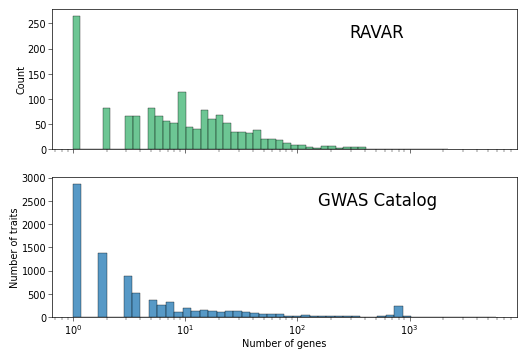

In [80]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(6, 4), sharex=True, sharey=False)
sns.histplot(ravar_genes.groupby('Trait Ontology id')['Gene Symbol'].nunique(), bins=50, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes.groupby('TRAIT_CODE')['MAPPED_GENE'].nunique(), bins=50, log_scale=True, ax=ax2)
#plt.yscale('log')
plt.xlabel('Number of genes')
plt.ylabel('Number of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)

### Export gene profiles

In [82]:
if True:
    for trait in tqdm(converted_ravar_genes['TRAIT_CODE'].unique()):
        gda = converted_ravar_genes.loc[converted_ravar_genes['TRAIT_CODE'] == trait, ('Gene Symbol', 'Ensembl ID','Entrez', 'P-value')]
        gda.to_csv(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/', trait+ '_RV.txt'), sep='\t', index=False)

100%|██████████| 1468/1468 [00:13<00:00, 110.59it/s]


In [187]:
if False:
    for trait in tqdm(overlap_traits):
        gda = converted_gwas_genes.loc[converted_gwas_genes['TRAIT_CODE'] == trait, ('MAPPED_GENE', 'SNP_GENE_IDS', 'P-VALUE', 'Entrez')]
        gda.columns = ['Gene Symbol', 'Ensembl ID', 'P-value', 'Entrez']
        gda.to_csv(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/', trait+ '_CV.txt'), sep='\t', index=False)

In [32]:
gwas_genes['TRAIT_CODE'].nunique()

7908

## Trait Overlap

No additional filtering

In [63]:
rare_traits = ravar_genes['TRAIT_CODE'].unique()
common_traits = gwas_genes['TRAIT_CODE'].unique()

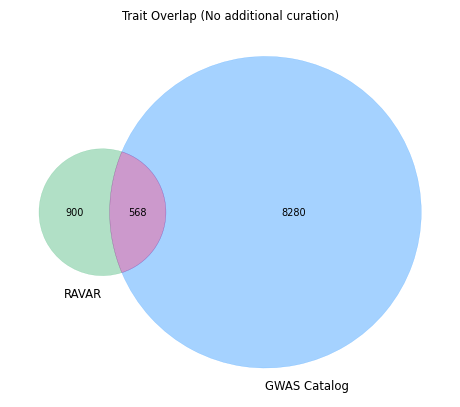

In [64]:
v = venn2([set(rare_traits), set(common_traits)], set_labels=('RAVAR', 'GWAS Catalog'))
v.get_patch_by_id('10').set_color('mediumseagreen')
v.get_patch_by_id('01').set_color('dodgerblue')
v.get_patch_by_id('11').set_color('purple')
plt.title('Trait Overlap (No additional curation)')
plt.savefig(os.path.join(figdir, 'trait_overlap_venn2.png'), dpi=400, bbox_inches='tight')

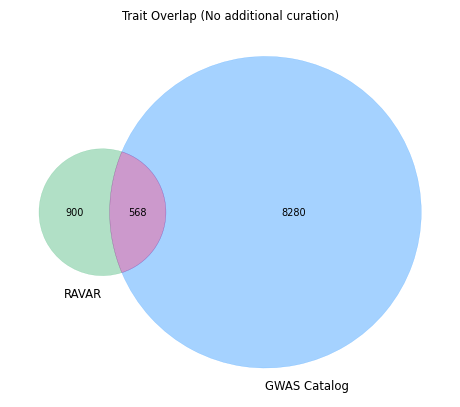

In [65]:
v = venn2([set(rare_traits), set(common_traits)], set_labels=('RAVAR', 'GWAS Catalog'))
v.get_patch_by_id('10').set_color('mediumseagreen')
v.get_patch_by_id('01').set_color('dodgerblue')
v.get_patch_by_id('11').set_color('purple')
plt.title('Trait Overlap (No additional curation)')
plt.savefig(os.path.join(figdir, 'trait_overlap_venn2.png'), dpi=400, bbox_inches='tight')

No background traits

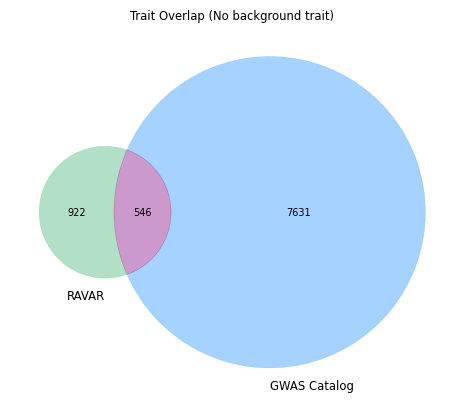

In [66]:
v = venn2([set(rare_traits), set(gwas_genes[gwas_genes['MAPPED BACKGROUND TRAIT URI'].isna()]['TRAIT_CODE'].unique())], set_labels=('RAVAR', 'GWAS Catalog'))
v.get_patch_by_id('10').set_color('mediumseagreen')
v.get_patch_by_id('01').set_color('dodgerblue')
v.get_patch_by_id('11').set_color('purple')
plt.title('Trait Overlap (No background trait)')
plt.savefig(os.path.join(figdir, 'trait_overlap_venn2_1.png'), dpi=400, bbox_inches='tight')

In [67]:
gwas_genes.head()

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,logp,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE,DATE ADDED TO CATALOG,INITIAL SAMPLE SIZE
0,25673412,2015-02-12,Hip circumference adjusted for BMI,TSEN15,ENSG00000198860,0.0,6.000000e-10,0.0232,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,9.221849,NaN,NaN,EFO_0008039,2017-05-23,"up to 56,910 European ancestry men, up to 86,5..."
1,25673412,2015-02-12,Hip circumference adjusted for BMI,HMGXB4,ENSG00000100281,0.0,4.000000e-08,0.0207,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,7.397940,NaN,NaN,EFO_0008039,2017-05-23,"up to 56,910 European ancestry men, up to 86,5..."
2,25673412,2015-02-12,Hip circumference adjusted for BMI,LINC02373,ENSG00000257507,0.0,4.000000e-09,0.0233,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,8.397940,NaN,NaN,EFO_0008039,2017-05-23,"up to 56,910 European ancestry men, up to 86,5..."
3,25673412,2015-02-12,Hip circumference adjusted for BMI,PLAG1,ENSG00000181690,0.0,9.000000e-10,0.0282,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,9.045757,NaN,NaN,EFO_0008039,2017-05-23,"up to 56,910 European ancestry men, up to 86,5..."
4,25673412,2015-02-12,Hip circumference adjusted for BMI,MTMR11,ENSG00000014914,0.0,6.000000e-25,0.0413,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,24.221849,NaN,NaN,EFO_0008039,2017-05-23,"up to 56,910 European ancestry men, up to 86,5..."


No background traits and summary stats present

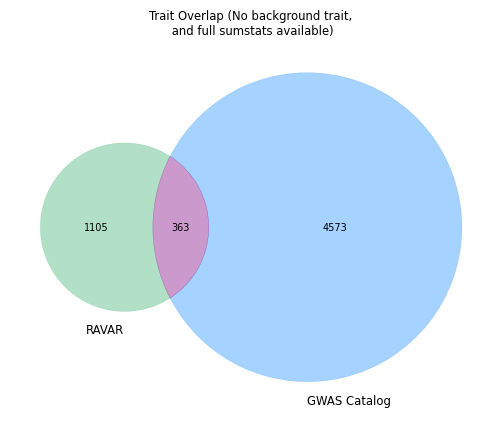

In [68]:
v = venn2([set(rare_traits), set(gwas_genes[(gwas_genes['MAPPED BACKGROUND TRAIT URI'].isna()) & (~gwas_genes['SUMMARY STATS LOCATION'].isna())]['TRAIT_CODE'].unique())], set_labels=('RAVAR', 'GWAS Catalog'))
v.get_patch_by_id('10').set_color('mediumseagreen')
v.get_patch_by_id('01').set_color('dodgerblue')
v.get_patch_by_id('11').set_color('purple')
plt.title('Trait Overlap (No background trait,\n and full sumstats available)')
plt.savefig(os.path.join(figdir, 'trait_overlap_venn2_w_sumstats.png'), dpi=400, bbox_inches='tight')

Statistics of overlapping traits, not accounting for summary stats/background traits

In [69]:
overlap_traits = set(rare_traits).intersection(set(common_traits))
overlap_traits_sumstats = set(rare_traits).intersection(set(gwas_genes[(gwas_genes['MAPPED BACKGROUND TRAIT URI'].isna()) & (~gwas_genes['SUMMARY STATS LOCATION'].isna())]['TRAIT_CODE'].unique()))

How many are very broad? It doesn't appear there are any really problematic ones

In [70]:
gwas_study.loc[gwas_study.TRAIT_CODE.isin(overlap_traits)]['TRAIT_CODE'].value_counts()[0:15]

TRAIT_CODE
EFO_0010226      409
EFO_0004530      225
EFO_0004611      170
EFO_0004587      165
EFO_0004340      143
MONDO_0005148    129
EFO_0004308      126
MONDO_0004975    110
EFO_0004570       93
EFO_0004574       90
EFO_0006335       81
EFO_0006336       70
EFO_0001663       68
MONDO_0004979     67
EFO_0004339       66
Name: count, dtype: int64

In [71]:
# write to file
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_Jan20_2025.txt'), 'w') as f:
    for trait in overlap_traits:
        f.write(trait + '\n')

In [72]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_sumstats_Jan29_2025.txt'), 'w') as f:
    for trait in overlap_traits_sumstats:
        f.write(trait + '\n')

Text(0.7, 0.8, 'GWAS Catalog')

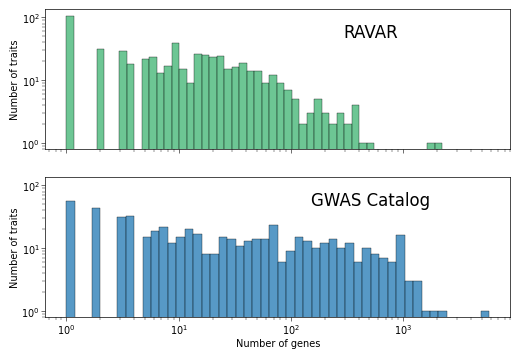

In [51]:
_, [ax1, ax2]  = plt.subplots(2, 1, figsize=(6, 4), sharex=True, sharey=True)
sns.histplot(ravar_genes[ravar_genes['TRAIT_CODE'].isin(overlap_traits)].groupby('Trait Ontology id')['Gene Symbol'].nunique(), bins=50, log_scale=True, ax=ax1, color='mediumseagreen')
sns.histplot(gwas_genes[gwas_genes.TRAIT_CODE.isin(overlap_traits)].groupby('TRAIT_CODE')['MAPPED_GENE'].nunique(), bins=50, log_scale=True, ax=ax2)
plt.yscale('log')
plt.xlabel('Number of genes')
ax1.set_ylabel('Number of traits')
ax2.set_ylabel('Number of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=12)

Plot cumulative number of traits with > x genes

In [73]:
rv_gene_counts = ravar_genes[ravar_genes['TRAIT_CODE'].isin(overlap_traits)].groupby('Trait Ontology id')['Gene Symbol'].nunique() * -1
   

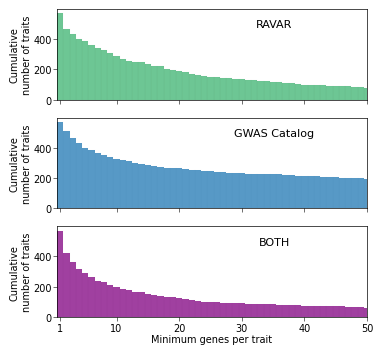

In [74]:
_, [ax1, ax2, ax3]  = plt.subplots(3, 1, figsize=(4, 4), sharex=True, sharey=True)
sns.histplot(ravar_genes[ravar_genes['TRAIT_CODE'].isin(overlap_traits)].groupby('Trait Ontology id')['Gene Symbol'].nunique() *-1, bins=[-5000] +[i for i in range(-50, -1)], discrete=True, ax=ax1, color='mediumseagreen', cumulative=True)
sns.histplot(gwas_genes[gwas_genes.TRAIT_CODE.isin(overlap_traits)].groupby('TRAIT_CODE')['MAPPED_GENE'].nunique()*-1, bins=[-5000] + [i for i in range(-50, -1)], discrete=True, ax=ax2, cumulative=True)
#plt.yscale('log')
plt.xlabel('Minimum genes per trait')
ax1.set_ylabel('Cumulative\nnumber of traits')
ax2.set_ylabel('Cumulative\nnumber of traits')
ax1.annotate('RAVAR', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=8)
ax2.annotate('GWAS Catalog', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=8)

overlap_counts = pd.concat([ravar_genes[ravar_genes['TRAIT_CODE'].isin(overlap_traits)].groupby('TRAIT_CODE')['Gene Symbol'].nunique(), gwas_genes[gwas_genes.TRAIT_CODE.isin(overlap_traits)].groupby('TRAIT_CODE')['MAPPED_GENE'].nunique()], axis=1)
overlap_counts.columns = ['RAVAR', 'GWAS Catalog']
overlap_counts['Min Genes'] = overlap_counts.min(axis=1)

sns.histplot(overlap_counts['Min Genes']*-1, bins=[-5000] + [i for i in range(-50, -1)], discrete=True, cumulative=True, color='purple', ax=ax3)
plt.xlabel('Minimum genes per trait')
ax3.set_ylabel('Cumulative\nnumber of traits')
ax3.annotate('BOTH', xy=(0.7, 0.8), xycoords='axes fraction', ha='center', fontsize=8)
plt.xlim(-50, -0.5)
# reverse the x axis
plt.gca().invert_xaxis()
_ = plt.xticks([-50, -40, -30, -20, -10, -1], [50, 40, 30, 20, 10, 1])
plt.savefig(os.path.join(figdir, 'genes_per_trait_cumulative_hists.jpg'), dpi=500, bbox_inches='tight')

In [75]:
min3_overlap_traits = overlap_counts[overlap_counts['Min Genes'] >2].index.values

In [76]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_Jan29_2025_min3_genes.txt'), 'w') as f:
    for trait in min3_overlap_traits:
        f.write(trait + '\n')

## Create study specific gene sets

How many traits if I restrict to individual studies with >= 3 genes?

I only lose 6 traits (excluding further effects from genes not in network), so I think it makes most sense to do study specific genesets and then use them as replicates? 

In [77]:
study_gene_counts = converted_gwas_genes.groupby(['STUDY ACCESSION', 'DISEASE/TRAIT', 'TRAIT_CODE']).Entrez.nunique().reset_index()

In [104]:
study_gene_counts['TRAIT_CODE'] = study_gene_counts.TRAIT_CODE.apply(lambda x: '_'.join(x.split(':')))
study_gene_counts = study_gene_counts.drop_duplicates()
study_gene_counts['StudyTrait'] = study_gene_counts['STUDY ACCESSION'] + '_' + study_gene_counts['TRAIT_CODE']

In [79]:
print('GWAS studies with  at least 3 genes:', len(study_gene_counts[study_gene_counts.Entrez > 2]))
print('Unique traits: ', study_gene_counts[study_gene_counts.Entrez > 2].TRAIT_CODE.nunique())

GWAS studies with  at least 3 genes: 14812
Unique traits:  3412


In [105]:
keep_gwas_studies = study_gene_counts[study_gene_counts.Entrez > 2]['StudyTrait'].unique()

In [108]:
converted_ravar_genes = converted_ravar_genes.rename(columns={'PMID_x':'PMID'})
rv_study_gene_counts = converted_ravar_genes.groupby(['PMID', 'TRAIT_CODE']).Entrez.nunique().reset_index()
rv_study_gene_counts['StudyTrait'] = rv_study_gene_counts['PMID'].astype(str) + '_' + rv_study_gene_counts['TRAIT_CODE']

In [109]:
print('RV studies with at least 3 genes:', len(rv_study_gene_counts[rv_study_gene_counts.Entrez > 2]))
print('Unique traits: ', rv_study_gene_counts[rv_study_gene_counts.Entrez > 2].TRAIT_CODE.nunique())

RV studies with at least 3 genes: 1464
Unique traits:  1114


In [110]:
keep_rv_studies = rv_study_gene_counts[rv_study_gene_counts.Entrez > 2].StudyTrait.unique()

In [111]:
rv_study_gene_counts[rv_study_gene_counts.TRAIT_CODE=='EFO_0004338']

,PMID,TRAIT_CODE,Entrez,StudyTrait
268,31367044.0,EFO_0004338,1,31367044.0_EFO_0004338
884,34375979.0,EFO_0004338,4,34375979.0_EFO_0004338
1720,34662886.0,EFO_0004338,6,34662886.0_EFO_0004338
2144,37262146.0,EFO_0004338,29,37262146.0_EFO_0004338


In [112]:

overlap_traits = set(rv_study_gene_counts[rv_study_gene_counts.Entrez > 2].TRAIT_CODE.unique()).intersection(study_gene_counts[study_gene_counts.Entrez > 2].TRAIT_CODE.unique()) 
print("Shared traits:", len(set(rv_study_gene_counts[rv_study_gene_counts.Entrez > 2].TRAIT_CODE.unique()).intersection(study_gene_counts[study_gene_counts.Entrez > 2].TRAIT_CODE.unique()) ))

Shared traits: 361


Now what if I combine those with too few?

In [208]:
rv_small = rv_study_gene_counts[rv_study_gene_counts.Entrez <= 2]
rv_small.head()

,PMID,TRAIT_CODE,Entrez
0,19571035.0,MONDO_0005148,1
1,19847924.0,EFO_0000537,1
6,20549515.0,EFO_0000537,2
9,20549515.0,MONDO_0005147,2
12,20852893.0,EFO_0000685,1


In [210]:
small_rv_genes = converted_ravar_genes.merge(rv_small.drop(columns=['Entrez']), on=['PMID', 'TRAIT_CODE'], how='right')

In [211]:
small_rv_counts = small_rv_genes.groupby('TRAIT_CODE').Entrez.nunique()
print('Additional traits:', len(small_rv_counts[small_rv_counts > 2]))

Additional traits: 38


In [212]:
added_traits = [x for x in small_rv_counts[small_rv_counts > 2].index.values if x not in rv_study_gene_counts[rv_study_gene_counts.Entrez > 2].TRAIT_CODE.unique()]
print('Actual additional traits:', len(added_traits) )
print('Added traits in GWAS:', len([x for x in added_traits if x in study_gene_counts[study_gene_counts.MAPPED_GENE > 2].TRAIT_CODE.unique()]))

Actual additional traits: 7
Added traits in GWAS: 5


In [213]:
[x for x in added_traits if x in study_gene_counts[study_gene_counts.MAPPED_GENE > 2].TRAIT_CODE.unique()]

['EFO_0000717', 'EFO_0003884', 'EFO_0003966', 'EFO_0004325', 'MONDO_0007079']

'EFO_0000717', systematic scleroderma
 'EFO_0003884', chronic renal insufficiency
 'EFO_0003966', eye disease
 'EFO_0004325', blood pressure on arteries
 'MONDO_0007079', alcohol dependence.

In [237]:
small_gwas = study_gene_counts[study_gene_counts.Entrez <= 2]
small_gwas.head()

,STUDY ACCESSION,DISEASE/TRAIT,TRAIT_CODE,Entrez
0,GCST000001,Age-related macular degeneration,EFO_0001365,1
1,GCST000002,Parkinson's disease,MONDO_0005180,1
2,GCST000004,QT interval,EFO_0004682,1
3,GCST000005,Parkinson's disease,MONDO_0005180,2
4,GCST000006,Age-related macular degeneration (wet),EFO_0001365,1


In [238]:
small_gwas_genes = gwas_genes.merge(small_gwas.drop(columns=['Entrez']), on=['STUDY ACCESSION', 'DISEASE/TRAIT', 'TRAIT_CODE'], how='right')

In [239]:
small_gwas_counts

TRAIT_CODE
EFO_0000094        2
EFO_0000095        1
EFO_0000096        1
EFO_0000174        2
EFO_0000178        2
                  ..
OBA_2050419        1
Orphanet_101953    2
Orphanet_391311    2
Orphanet_93957     1
Orphanet_98974     1
Name: MAPPED_GENE, Length: 6251, dtype: int64

In [240]:
small_gwas_counts = small_gwas.groupby('TRAIT_CODE').Entrez.nunique()
print('Additional traits:', len(small_gwas_counts[small_gwas_counts > 2]))

Additional traits: 0


Could look at using betas, but how standardized are the definitions across studies? Range seems pretty extreme, but if I log it I will get negative values, I guess could add 1 to all and then log it. 

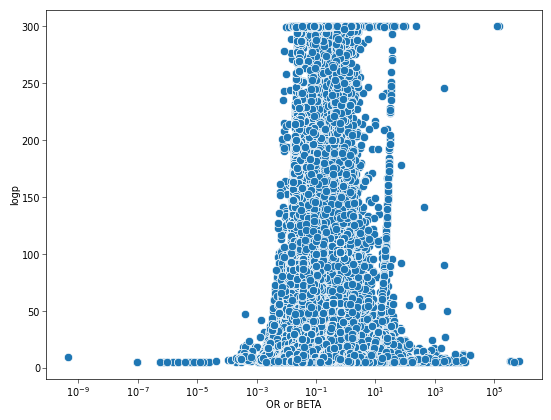

In [177]:
sns.scatterplot(converted_gwas_genes, x='OR or BETA', y='logp')
plt.xscale('log')

## Create updated gene sets


In [116]:
converted_ravar_genes['StudyTrait'] = converted_ravar_genes['PMID'].astype(str) + '_' + converted_ravar_genes['TRAIT_CODE']

In [119]:
if True:
    for trait in overlap_traits:
            gda = converted_ravar_genes.loc[converted_ravar_genes['TRAIT_CODE'] == trait, 
                                            ('Gene Symbol', 'Ensembl ID','Entrez', 'P-value', 'PMID', 'StudyTrait')]
            for study in gda[gda.StudyTrait.isin(keep_rv_studies)].PMID.unique():
                gda_out = gda[gda.PMID==study]
                gda_out = gda_out.sort_values(by='P-value', ascending=True).drop_duplicates(subset='Entrez', keep='first').drop(columns=['StudyTrait'])
                gda_out.to_csv(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/Jan_2025', 
                                        f'{study}_{trait}_RV.txt'), sep='\t', index=False)


In [120]:
converted_gwas_genes['StudyTrait'] = converted_gwas_genes['STUDY ACCESSION'] + '_' + converted_gwas_genes['TRAIT_CODE']

In [122]:
if True:
    for trait in tqdm(overlap_traits):
        gda = converted_gwas_genes.loc[converted_gwas_genes['TRAIT_CODE'] == trait, ('MAPPED_GENE', 'SNP_GENE_IDS', 'P-VALUE', 'Entrez', 'STUDY ACCESSION', 'StudyTrait')]
        for study in gda[gda['StudyTrait'].isin(keep_gwas_studies)]['STUDY ACCESSION'].unique():
            gda_out = gda[gda['STUDY ACCESSION']==study]
            gda_out.columns = ['Gene Symbol', 'Ensembl ID', 'P-value', 'Entrez', 'Study', 'StudyTrait']
            gda_out = gda_out.sort_values(by=['P-value'], ascending=True).drop_duplicates(subset='Entrez').drop(columns=['StudyTrait'])
            gda_out.to_csv(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/Jan_2025', f'{study}_{trait}_CV.txt'), sep='\t', index=False)

100%|██████████| 361/361 [00:42<00:00,  8.53it/s]


In [124]:
rare_common_pairs = []
rare_studies = {}
common_studies = {}
for trait in overlap_traits:
    rare_studies[trait] = set(keep_rv_studies).intersection(converted_ravar_genes[converted_ravar_genes.TRAIT_CODE==trait].PMID.unique())
    common_studies[trait] = set(keep_gwas_studies).intersection(converted_gwas_genes[converted_gwas_genes.TRAIT_CODE==trait]['STUDY ACCESSION'].unique())

In [399]:
common_studies

{'EFO_0010119': {'GCST010318',
  'GCST90091514',
  'GCST90092931',
  'GCST90133362',
  'GCST90269541',
  'GCST90269548',
  'GCST90301959'},
 'EFO_0005207': {'GCST004721', 'GCST90131426'},
 'EFO_0003959': {'GCST000547',
  'GCST009357',
  'GCST010379',
  'GCST012351',
  'GCST012352',
  'GCST012456',
  'GCST012458',
  'GCST90095043',
  'GCST90448958',
  'GCST90448959'},
 'EFO_0004234': {'GCST001572', 'GCST006956'},
 'EFO_0021506': {'GCST90133633'},
 'EFO_0000685': {'GCST000232',
  'GCST000677',
  'GCST000679',
  'GCST000917',
  'GCST001022',
  'GCST001454',
  'GCST002318',
  'GCST002323',
  'GCST002357',
  'GCST002433',
  'GCST002434',
  'GCST005568',
  'GCST005569',
  'GCST006048',
  'GCST006959',
  'GCST007843',
  'GCST009877',
  'GCST010730',
  'GCST011389',
  'GCST90013534',
  'GCST90013684',
  'GCST90018690',
  'GCST90018910',
  'GCST90131437',
  'GCST90132222',
  'GCST90132223',
  'GCST90132224',
  'GCST90244058',
  'GCST90244060',
  'GCST90258644',
  'GCST90258645',
  'GCST90446530

In [138]:
def prioritize_gwas_studies(gwas_data, trait, keep_studies, study_info, n=5, verbose=True):
    study_info['StudyTrait'] = study_info['STUDY ACCESSION'] + '_' + study_info['TRAIT_CODE']
    study_subset = study_info[study_info['STUDY ACCESSION'].isin(gwas_data[gwas_data.TRAIT_CODE==trait]['STUDY ACCESSION'])]
    
    study_subset = study_subset[study_subset['StudyTrait'].isin(keep_studies)]
    initial_count = len(study_subset)
    study_subset = study_subset.dropna(subset=['N'])

    out_studies = []
    if len(study_subset) > n:
        # remove those with background traits
        study_subset = study_subset[study_subset['MAPPED BACKGROUND TRAIT URI'].isna()]
        if len(study_subset) > n:
            #priortize those with summary stats available
            if len(study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]) > n:
                study_subset = study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]
            else:
                out_studies += list(study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()].drop_duplicates(subset=['COHORTID'])['STUDY ACCESSION'].values)
                n -= len(out_studies)
                study_subset = study_subset[study_subset['SUMMARY STATS LOCATION'].isna()]
            # then sort by population size.
            study_subset = study_subset.sort_values(['N', 'ASSOCIATION COUNT'], ascending=False)
            # then select by cohort
            has_cohort = study_subset[~study_subset.COHORT.isna()]
            keep_cohort = has_cohort.drop_duplicates(subset='COHORTID', keep='first').drop_duplicates(subset='DATE ADDED TO CATALOG')
            if len(keep_cohort) >= n:
                out_studies += list(keep_cohort['STUDY ACCESSION'].values[0:n])
            else:
                out_studies += list(keep_cohort['STUDY ACCESSION'].values)
                n = n - len(keep_cohort)
                out_studies += list(study_subset[study_subset.COHORT.isna()]['STUDY ACCESSION'].values[0:n])
        else:
            out_studies += list(study_subset['STUDY ACCESSION'].values)
    else:
        study_subset = study_subset.sort_values(['N', 'ASSOCIATION COUNT'], ascending=False)
        keep_cohort = study_subset.drop_duplicates(subset='COHORTID', keep='first').drop_duplicates(subset='DATE ADDED TO CATALOG')
        out_studies += list(keep_cohort['STUDY ACCESSION'].values)
    if verbose:
        print(trait, initial_count, len(out_studies))
    return out_studies

In [126]:
def extract_sample_size(size_str):
    try:
        size_str = size_str.replace(',', '')
    except AttributeError:
        #print(size_str)
        return np.nan
    size_str_parts = size_str.split(' ')
    numeric = [x for x in size_str_parts if x.isnumeric()]
    return sum([int(n) for n in numeric])

In [134]:
cohort_dict = {'UKBB': 'UKB', 'Taiwan': 'TWB', 'Lifelines':'LifeLines', 'Qatar Genome Program (QGP)':'QGP', 
               'UKBB White British': 'UKB', 'GOCS_Chilean':'GOCS'}

gwas_study['COHORT'] = gwas_study.COHORT.apply(lambda x: cohort_dict[x] if x in cohort_dict else x)
gwas_study['COHORTID'] = gwas_study.apply(lambda x: x.COHORT if (isinstance(x.COHORT, str)) and (x.COHORT.upper() != 'MULTIPLE') else x['STUDY ACCESSION'], axis=1)
gwas_study['N'] = gwas_study['INITIAL SAMPLE SIZE'].apply(lambda x: extract_sample_size(x))

In [139]:
subset_common = {}
for trait in common_studies:
     subset_common[trait] = prioritize_gwas_studies(converted_gwas_genes, trait, keep_gwas_studies, gwas_study, verbose=False)

In [129]:
rv_study_info = pd.read_csv('/cellar/users/snwright/Data/RareCommon/RAVAR/pmid_info_manual.txt', sep='\t')
rv_study_info['PMID'] = rv_study_info['PMID'].astype(float)

In [142]:
def prioritize_rv_studies(rv_data, trait, study_info, keep_studies, n=5):
    all_studies = rv_data.groupby(['PMID', 'TRAIT_CODE', 'Trait Label', 'StudyTrait']).Entrez.nunique().reset_index()
    study_subset = all_studies[(all_studies.TRAIT_CODE==trait) & (all_studies.StudyTrait.isin(keep_studies))]
    study_subset = study_subset.merge(study_info, on='PMID', how='left')
    if len(study_subset) <= 5:
        return list(study_subset['PMID'].unique())
    else: # prioritize
        study_subset = study_subset.sort_values(by=['N', 'Entrez'], ascending=False).drop_duplicates('COHORT')
        if len(study_subset) <= 5:
            return list(study_subset['PMID'].unique())
        else:
            return list(study_subset['PMID'].values[0:5])

In [143]:
subset_rare = {}
for trait in rare_studies:
     subset_rare[trait] = prioritize_rv_studies(converted_ravar_genes, trait, rv_study_info, keep_rv_studies)

In [144]:
subset_numbers = pd.DataFrame({'rare': {t:len(subset_rare[t]) for t in subset_rare}, 
             'common': {t: len(subset_common[t]) for t in subset_common}})

In [145]:
subset_numbers.sum()

rare       547
common    1061
dtype: int64

In [146]:
rare_common_pairs = []
for trait in overlap_traits:
    i=0 
    for r in subset_rare[trait]:
        for c in subset_common[trait]:
            rare_common_pairs.append((f'{str(r)}_{trait}', f'{c}_{trait}', i))
            i+=1

In [147]:
all_pairs = pd.DataFrame(rare_common_pairs, columns=['R', 'C', 'idx']).sort_values('idx')
all_pairs

,R,C,idx
0,34375979.0_EFO_0004631,GCST90000618_EFO_0004631,0
988,34375979.0_MONDO_0002009,GCST009979_MONDO_0002009,0
993,34375979.0_EFO_0020690,GCST90239636_EFO_0020690,0
998,34375979.0_EFO_0004193,GCST90013410_EFO_0004193,0
1003,30206357.0_EFO_0004842,GCST90002302_EFO_0004842,0
...,...,...,...
357,37262146.0_EFO_0004526,GCST004602_EFO_0004526,24
1236,36280733.0_EFO_0004611,GCST90278638_EFO_0004611,24
303,26715663.0_MONDO_0005148,GCST90086072_MONDO_0005148,24
258,36038634.0_EFO_0000384,GCST003044_EFO_0000384,24


In [148]:
all_pairs['R'].to_csv('/cellar/users/snwright/Data/RareCommon/inputs/Jan_2025/rare.traitlist', index=False, header=False)
all_pairs['C'].to_csv('/cellar/users/snwright/Data/RareCommon/inputs/Jan_2025/common.traitlist', index=False, header=False)

In [149]:
# Doing all combinations is not plausible. 
len(rare_common_pairs)

1809

(array([222.,   0.,   0.,  54.,   0.,   0.,   0.,  19.,   0.,   0.,   0.,
         19.,   0.,   0.,   0.,  13.,   0.,   0.,   0.,   8.,   0.,   0.,
          0.,   7.,   0.,   0.,   4.,   0.,   0.,   0.,   4.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.  ,  1.26,  1.52,  1.78,  2.04,  2.3 ,  2.56,  2.82,  3.08,
         3.34,  3.6 ,  3.86,  4.12,  4.38,  4.64,  4.9 ,  5.16,  5.42,
         5.68,  5.94,  6.2 ,  6.46,  6.72,  6.98,  7.24,  7.5 ,  7.76,
         8.02,  8.28,  8.54,  8.8 ,  9.06,  9.32,  9.58,  9.84, 10.1 ,
        10.36, 10.62, 10.88, 11.14, 11.4 , 11.66, 11.92, 12.18, 12.44,
        12.7 , 12.96, 13.22, 13.48, 13.74, 14.  ]),
 <BarContainer object of 50 artists>)

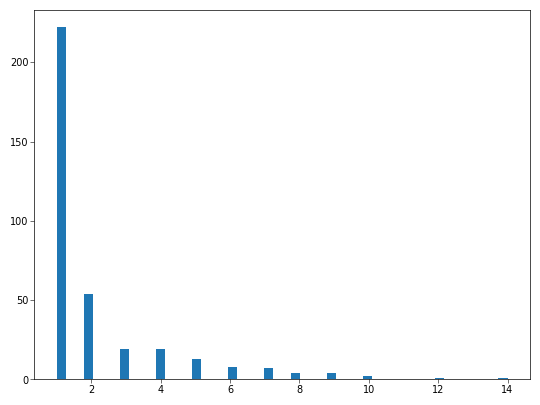

In [266]:
plt.hist([len(rare_studies[x]) for x in rare_studies], bins=50)

In [274]:
z = pd.DataFrame.from_dict({'common':{x: len(common_studies[x]) for x in common_studies}}).sort_values('common', ascending=False)
z2 = pd.DataFrame.from_dict({'rare':{x: len(rare_studies[x]) for x in rare_studies}}).sort_values('rare', ascending=False)

In [275]:
zz = z.join(z2)

In [277]:
zz['combo'] = zz.common * zz.rare

In [280]:
zz.sum()

common     3326
rare        739
combo     12839
dtype: int64

In [284]:
gwas_study

,DISEASE/TRAIT,ASSOCIATION COUNT,STUDY ACCESSION,COHORT,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE
0,Periodontitis,2,GCST002781,NaN,NaN,NaN,EFO_0000649
1,Chronic obstructive pulmonary disease,3,GCST002624,NaN,NaN,NaN,EFO_0000341
2,Chronic bronchitis in chronic obstructive pulm...,1,GCST002621,NaN,http://www.ebi.ac.uk/efo/EFO_0000341,NaN,EFO_0006505
3,Axial length,1,GCST002836,NaN,NaN,NaN,EFO_0005318
4,Corneal curvature,1,GCST002834,NaN,NaN,NaN,EFO_0004345
...,...,...,...,...,...,...,...
133984,Height,0,GCST90245992,multiple,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0004339
133985,Height,0,GCST90245993,multiple,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO:0004302
133986,Height,0,GCST90245993,multiple,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0004339
133987,Height,0,GCST90245994,multiple,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO:0004302


## Trait Information

In [47]:
def collect_ancestor_counts(trait_set, efo):
    efo_counts = defaultdict(int)
    failed_traits = []
    for trait in list(trait_set):
        trait = trait.replace('_', ':')
        if trait in efo.nodes:
            for ancestor in list(nx.descendants(efo, trait)):
                efo_counts[ancestor] += 1
        else:
            failed_traits.append(trait)
    return efo_counts, failed_traits

def parent_counts_min_genes(overlap_counts, efo, thresholds=[1,3,5,10]):
    counts = []
    for th in thresholds:
        traits = overlap_counts[overlap_counts['Min Genes'] >= th].index.values
        efo_counts, failed_traits = collect_ancestor_counts(traits, efo)
        counts.append(efo_counts)
    counts_df = pd.DataFrame({th:efo_counts for th, efo_counts in zip(thresholds, counts)})
    return counts_df




In [29]:
all_counts = parent_counts_min_genes(overlap_counts, efo, thresholds=[1,3,5,10])

NameError: name 'parent_counts_min_genes' is not defined

In [49]:
all_counts.loc['EFO:0000408']

1     284.0
3     213.0
5     175.0
10    116.0
Name: EFO:0000408, dtype: float64

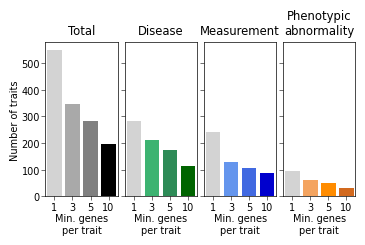

In [50]:
def plot_category_totals(all_counts, trait, title=None, palette=['lightgrey', 'mediumseagreen', 'seagreen', 'darkgreen'], thresholds=[1,3,5,10], ax=None, **kwargs):
    plot_df = all_counts.loc[trait].reset_index()
    if title is not None:
        ax.set_title(title)
    sns.barplot(data=plot_df[plot_df['index'].isin(thresholds)], x='index', y=trait, hue='index', palette=palette, saturation=1,  ax=ax, **kwargs)
    
    
_, [ax4, ax1, ax2, ax3]  = plt.subplots(1,4, figsize=(4, 2), sharey=True, gridspec_kw={'wspace':0.1})
plot_category_totals(all_counts, 'EFO:0000001', ax=ax4, legend=False, palette=['lightgrey', 'darkgrey', 'grey', 'black'], title='Total')
plot_category_totals(all_counts, 'EFO:0000408', ax=ax1, legend=False, title='Disease')
plot_category_totals(all_counts, 'EFO:0001444', title='Measurement', palette=['lightgrey', 'cornflowerblue', 'royalblue', 'mediumblue'], ax=ax2, legend=False)
plot_category_totals(all_counts, 'HP:0000118', title='Phenotypic\nabnormality', palette=['lightgrey', 'sandybrown', 'darkorange', 'chocolate'], ax=ax3, legend=False)
for ax in [ax1, ax2, ax3, ax4]:
#     ax.set_xticks([-0.3, -0.1, 0.1, 0.3], [1,3,5,10])
    ax.set_xlabel('Min. genes\nper trait')
#     ax.set_xlim(-0.4, 0.4)
ax4.set_ylabel('Number of traits')
plt.savefig(os.path.join(figdir, 'updated_overlap_trait_counts_total_per_cat.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join(figdir, 'updated_overlap_trait_counts_total_per_cat.svg'), dpi=500, bbox_inches='tight')

In [51]:
min3 = all_counts.loc[['EFO:0000001','EFO:0000408','EFO:0001444','HP:0000118']]

In [52]:
min3 = overlap_counts[overlap_counts['Min Genes']>= 3]

In [104]:
def assign_trait_to_global(trait, efo, high_level_terms=['EFO:0000408','EFO:0001444','HP:0000118']):
    trait = trait.replace('_', ':')
    high_level_parents = []
    if trait in efo.nodes:
        for ancestor in list(nx.descendants(efo, trait)):
            if ancestor in high_level_terms:
                high_level_parents.append(ancestor)
    else:
        print(trait, 'not in efo graph')
    return high_level_parents

def assign_trait_list_to_global(trait_list, efo, high_level_terms=['EFO:0000408','EFO:0001444','HP:0000118']):
    groups = {trait:[] for trait in high_level_terms}
    for trait in trait_list:
        parents = assign_trait_to_global(trait ,efo, high_level_terms=high_level_terms)
        try:
            for term in parents:
                groups[term].append(trait)
        except:
            print(parents)
    return groups

In [54]:
groups = assign_trait_list_to_global(min3.index.values, efo)

EFO:0003761 not in efo graph
EFO:0005192 not in efo graph


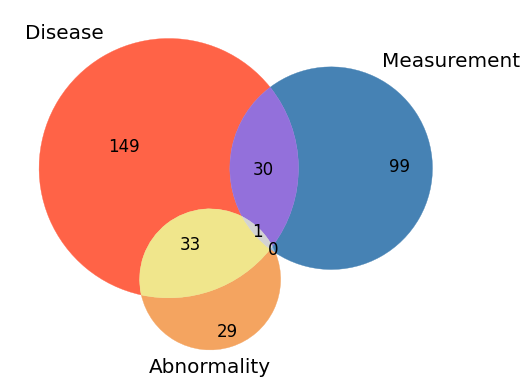

In [55]:
plt.rcParams.update({'font.size': 12})
v = venn3([set(groups['EFO:0000408']), set(groups['EFO:0001444']), set(groups['HP:0000118'])], 
          set_labels=('Disease', 'Measurement', 'Abnormality'))
v.get_patch_by_id('100').set_color('tomato')
v.get_patch_by_id('010').set_color('steelblue')
v.get_patch_by_id('110').set_color('mediumpurple')
v.get_patch_by_id('111').set_color('lightgrey')
v.get_patch_by_id('001').set_color('sandybrown')
v.get_patch_by_id('101').set_color('khaki')
for patch in ['100', '010','110', '111', '001', '101']:
    v.get_patch_by_id(patch).set_alpha(1)
#plt.title('Trait Overlap (No additional curation)')
plt.savefig(os.path.join(figdir, 'trait_overlap_venn3.svg'), dpi=400, bbox_inches='tight')

Subcategories

In [56]:
disease_cats = [x for x in efo.predecessors('EFO:0000408')]
disease_counts = {x:all_counts.loc[x, (3)] for x in disease_cats if x in all_counts.index}
disease_counts = {efo.nodes[x]['name']:disease_counts[x] for x in disease_counts}

In [57]:
def plot_subcategories(parent, efo, all_counts, th=3, display_min=10, **kwargs):
    disease_cats = [x for x in efo.predecessors(parent)]
    disease_counts = {x:all_counts.loc[x, (th)] for x in disease_cats if x in all_counts.index}
    disease_counts = {efo.nodes[x]['name']:disease_counts[x] for x in disease_counts}
    plot_df = pd.DataFrame({'Trait Count': disease_counts}).sort_values(by='Trait Count', ascending=False).reset_index()
    sns.barplot(plot_df[plot_df['Trait Count'] >= display_min], y='index', x='Trait Count', **kwargs)
    plt.ylabel('')
    plt.xlim(0,48 )

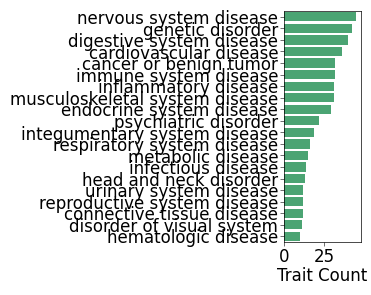

In [58]:
_ = plt.figure(figsize=(1, 3))
plot_subcategories('EFO:0000408', efo, all_counts, color='mediumseagreen')
plt.savefig(os.path.join(figdir, 'disease_counts.png'), dpi=400, bbox_inches='tight')

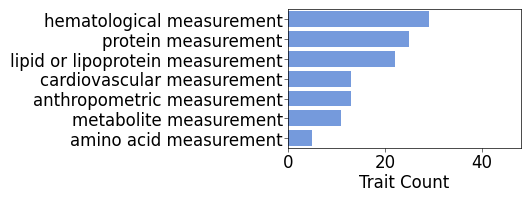

In [59]:
_ = plt.figure(figsize=(3, 1.8))
plot_subcategories('EFO:0001444', efo, all_counts, color='cornflowerblue', display_min=5)
plt.savefig(os.path.join(figdir, 'measurement_counts.png'), dpi=400, bbox_inches='tight')

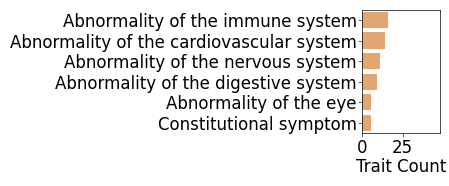

In [60]:
_ = plt.figure(figsize=(1, 1.6))
plot_subcategories('HP:0000118', efo, all_counts, color='sandybrown', display_min=5)
plt.savefig(os.path.join(figdir, 'pheno_counts.png'), dpi=400, bbox_inches='tight')

## Development

In [61]:
trait_info = pd.read_csv(os.path.join(datadir,'RAVAR' ,'trait_allinfo_06112024.txt'),sep='\t')
trait_info['TRAIT_CODE'] = trait_info['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)

In [62]:
trait_info.head()

,Trait Ontology id,Trait Label,EFO description,EFO synonym,EFO Tree,TRAIT_CODE
0,EFO:0009827,abnormal result of diagnostic imaging,NaN,NaN,abnormal result of diagnostic imaging|test res...,EFO_0009827
1,EFO:0004536,total blood protein measurement,NaN,serum total protein;TBP,total blood protein measurement|hematological ...,EFO_0004536
2,EFO:0004838,calcium measurement,NaN,calcium levels,calcium measurement|measurement|information en...,EFO_0004838
3,EFO:0004696,sex hormone-binding globulin measurement,NaN,SHBG levels;SHBG level,sex hormone-binding globulin measurement|glyco...,EFO_0004696
4,EFO:0004532,serum gamma-glutamyl transferase measurement,NaN,GGT measurement;Gamma gluatamyl transferase le...,serum gamma-glutamyl transferase measurement|l...,EFO_0004532


In [63]:
efo_tree = defaultdict(int)
trait_weights = defaultdict(int)
failed = []
for i in tqdm(range(len(trait_info))):
    try:
        all_trees = trait_info['EFO Tree'][i].split('; ')
        unique_edges = set()
        for tree in all_trees:
            tree = tree.split('|')
            for j in range(len(tree)-1):
                unique_edges.add((tree[j], tree[j+1]))
        for j in list(unique_edges):
                efo_tree[j] += 1
                trait_weights[j[1]] += 1
    except AttributeError:
        if type(trait_info['EFO Tree'][i]) == float:
            failed.append(i)


100%|██████████| 2005/2005 [00:00<00:00, 53666.06it/s]


In [64]:
efo_graph = pd.DataFrame.from_dict(efo_tree, orient='index', columns=['Count'])
efo_graph['Child'] = [x[0] for x in efo_graph.index]
efo_graph['Parent'] = [x[1] for x in efo_graph.index]

In [65]:
efo_graph.reset_index(drop=True).to_csv(os.path.join(outdir, 'efo_graph.csv'), index=False)


In [66]:
pd.DataFrame.from_dict(trait_weights, orient='index', columns=['Count']).reset_index(drop=False).to_csv(os.path.join(outdir, 'trait_weights.csv'), index=False)

In [67]:
print('Not mapped to EFO:', len(failed), '/', len(trait_info))
print(trait_info.iloc[failed, 0:2])
print('Number of associations of unmapped traits')
ravar_genes[ravar_genes['Trait Ontology id'].isin(trait_info.iloc[failed, 0])]['Trait Ontology id'].value_counts()

Not mapped to EFO: 10 / 2005
     Trait Ontology id                                        Trait Label
235       Orphanet:846                                  Alpha-thalassemia
348     Orphanet:79161                Disorder of carbohydrate metabolism
727      Orphanet:2686                                 Cyclic neutropenia
747       Orphanet:332             Congenital intrinsic factor deficiency
928      Orphanet:2543                          Microphthalmia - cataract
1176   Orphanet:285014  Rare disease with thoracic aortic aneurysm and...
1400   Orphanet:331244  Other immunodeficiency syndrome with predomina...
1439     Orphanet:1479  Atrial septal defect - atrioventricular conduc...
1442   Orphanet:220448  Macrothrombocytopenia with mitral valve insuff...
1639   Orphanet:227535                           Hereditary breast cancer
Number of associations of unmapped traits


Trait Ontology id
Orphanet:846       65
Orphanet:79161     26
Orphanet:332       13
Orphanet:2543       9
Orphanet:2686       7
Orphanet:331244     3
Orphanet:220448     3
Orphanet:285014     2
Orphanet:1479       2
Name: count, dtype: int64

## Visualize available diseases

In [68]:
G = nx.from_pandas_edgelist(efo_graph, source='Parent', target='Child', edge_attr='Count', create_using=nx.DiGraph())

In [69]:
def get_all_leaves(G, start_node):
    all_nodes = list(nx.dfs_preorder_nodes(G, start_node))
    leaves = [node for node in all_nodes if G.out_degree(node) == 0]
    return leaves

def get_rv_per_trait(trait_label, trait_info, ravar_genes):
    try:
        trait_id = trait_info[trait_info['Trait Label'] == trait_label]['Trait Ontology id'].values[0]
    except:
        print('Trait not found:', trait_label)
        return pd.DataFrame()
    trait_rv = ravar_genes[ravar_genes['Trait Ontology id'] == trait_id]
    return trait_rv.drop_duplicates(subset='Ensembl ID')

def get_rvs_per_leaf(G, start_node, trait_info, ravar_genes):
    leaves = get_all_leaves(G, start_node)
    rvs = {}
    for leaf in leaves:
        rvs[leaf] = len(get_rv_per_trait(leaf, trait_info, ravar_genes))
    return pd.DataFrame({'RVCount': rvs})

def get_traits_with_x_rvs(G, parent, trait_info, ravar_genes, x_list=[1]):
    counts = get_rvs_per_leaf(G, parent, trait_info, ravar_genes)
    x_values = [len(counts[counts['RVCount'] >= x]) for x in x_list]
    return x_values

def get_traits_per_leaf_from_overlap(G, parent, trait_info, overlap_counts, x_list=[1]):
    leaves = get_all_leaves(G, parent)
    leaf_map = dict(zip(trait_info['Trait Label'], trait_info['TRAIT_CODE']))
    leaves_in_overlap = [leaf_map[leaf] for leaf in leaves if (leaf in leaf_map) and (leaf_map[leaf] in overlap_counts.index)]
    overlaps = overlap_counts.loc[leaves_in_overlap]
    x_values = [len(overlaps[overlaps['Min Genes'] >= x]) for x in x_list]
    return x_values

In [70]:
def evaluate_available_traits(source, overlap_counts=None, palette=['lightgrey', 'mediumseagreen', 'seagreen', 'darkgreen']):
    disease_categories = list(G.successors(source))
    category_counts = {}
    print('Getting Category Counts')
    
    for category in disease_categories:
        if overlap_counts is not None:
            category_counts[category] = get_traits_per_leaf_from_overlap(G, category, trait_info, overlap_counts, x_list=[1, 2, 3,5,10,20])
        else:
            category_counts[category] = get_traits_with_x_rvs(G, category, trait_info, ravar_genes, x_list=[1, 2, 3,5,10,20])
    category_counts_df = pd.DataFrame.from_dict(category_counts, columns=[1, 2, 3, 5, 10, 20], orient='index')
    category_counts_df['Trait'] = category_counts_df.index
    category_counts_df = category_counts_df.melt(id_vars='Trait', var_name='th', value_name='Count')
    print('Getting total counts')
    if overlap_counts is not None:
        total_disease = get_traits_per_leaf_from_overlap(G, source, trait_info, overlap_counts, x_list=[1, 2, 3,5,10,20])
    else:
        total_disease = get_traits_with_x_rvs(G, source, trait_info, ravar_genes, x_list=[1, 2, 3,5,10,20])
    
    total_disease_df = pd.DataFrame({'Total': total_disease, 'th': [1,2,3,5, 10,20], 'Trait':'Total'})
    print('Plotting')
    _, [ax1, ax2] = plt.subplots(2,1, figsize=(3, 5), height_ratios=[0.1, 1])
    sns.barplot(data=total_disease_df[total_disease_df['th'].isin([1,3,5,10])], y='Trait', x='Total', hue='th', palette=palette, ax=ax1)
    sns.barplot(data=category_counts_df[category_counts_df['th'].isin([1,3,5,10])].sort_values(by='Count', ascending=False), y='Trait', x='Count', hue='th', palette=palette, ax=ax2)
    return category_counts_df
    
def plot_category_totals(source, overlap_counts=None, palette=['lightgrey', 'mediumseagreen', 'seagreen', 'darkgreen'], ax=None, **kwargs):
    if overlap_counts is not None:
        total_disease = get_traits_per_leaf_from_overlap(G, source, trait_info, overlap_counts, x_list=[1, 2, 3,5,10,20])
    else:
        total_disease = get_traits_with_x_rvs(G, source, trait_info, ravar_genes, x_list=[1, 2, 3,5,10,20])
    total_disease_df = pd.DataFrame({'Total': total_disease, 'th': [1,2,3,5, 10,20], 'Trait':'Total'})
    print(total_disease_df)
    sns.barplot(data=total_disease_df[total_disease_df['th'].isin([1,3,5,10])], x='Trait', y='Total', hue='th', palette=palette, ax=ax, **kwargs)

   Total  th  Trait
0    142   1  Total
1    121   2  Total
2    104   3  Total
3     80   5  Total
4     45  10  Total
5     17  20  Total
   Total  th  Trait
0    407   1  Total
1    285   2  Total
2    238   3  Total
3    186   5  Total
4    125  10  Total
5     74  20  Total
   Total  th  Trait
0    211   1  Total
1    125   2  Total
2    105   3  Total
3     84   5  Total
4     69  10  Total
5     54  20  Total
   Total  th  Trait
0     44   1  Total
1     33   2  Total
2     25   3  Total
3     18   5  Total
4     10  10  Total
5      3  20  Total


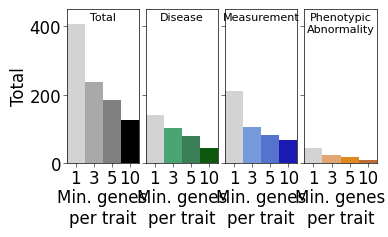

In [71]:
_, [ax4, ax1, ax2, ax3]  = plt.subplots(1,4, figsize=(4, 2), sharey=True, gridspec_kw={'wspace':0.1})
plot_category_totals('disease', overlap_counts=overlap_counts, ax=ax1, legend=False, )
plot_category_totals('experimental factor', overlap_counts=overlap_counts, ax=ax4, legend=False, palette=['lightgrey', 'darkgrey', 'grey', 'black'])
plot_category_totals('measurement', overlap_counts=overlap_counts, palette=['lightgrey', 'cornflowerblue', 'royalblue', 'mediumblue'], ax=ax2, legend=False)
plot_category_totals('Phenotypic abnormality', overlap_counts=overlap_counts, palette=['lightgrey', 'sandybrown', 'darkorange', 'chocolate'], ax=ax3, legend=False)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-0.3, -0.1, 0.1, 0.3], [1,3,5,10])
    ax.set_xlabel('Min. genes\nper trait')
    ax.set_xlim(-0.4, 0.4)
ax1.set_ylabel('Number of traits')
for i in range(4):
    [ax1, ax2, ax3, ax4][i].annotate(['Disease', 'Measurement', 'Phenotypic\nAbnormality', 'Total'][i], xy=(0.5, 0.98), xycoords='axes fraction', ha='center', va='top', fontsize=8)
plt.ylim(0, 450)
plt.savefig(os.path.join(figdir, 'overlap_trait_counts_total_per_cat.png'), dpi=500, bbox_inches='tight')

   Total  th  Trait
0    407   1  Total
1    285   2  Total
2    238   3  Total
3    186   5  Total
4    125  10  Total
5     74  20  Total


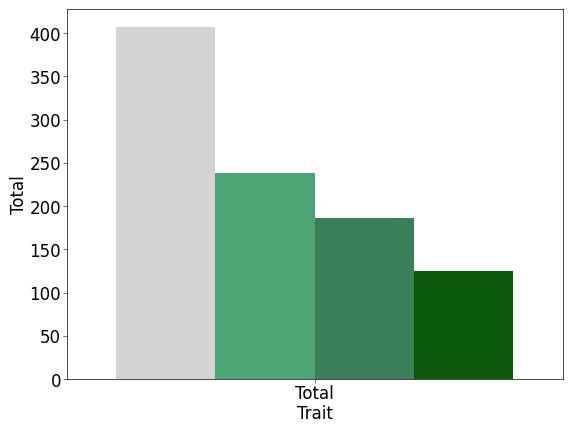

In [72]:
plot_category_totals('experimental factor', overlap_counts=overlap_counts, legend=False) 

Getting Category Counts
Getting total counts
Plotting


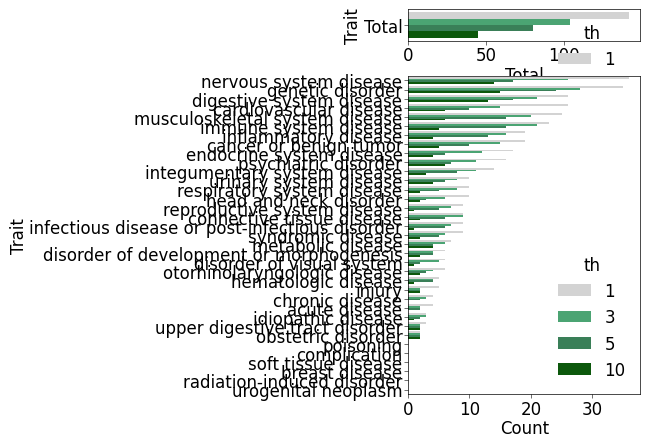

In [73]:
disease_df = evaluate_available_traits('disease', overlap_counts=overlap_counts)
plt.savefig(os.path.join(figdir, 'disease_overlap_trait_counts_threshold.png'), dpi=500, bbox_inches='tight')

In [74]:
disease_df[disease_df.th == 3].to_csv(os.path.join(outdir, 'disease_traits_with_3_rvs.csv'), index=False)

Getting Category Counts
Getting total counts
Plotting


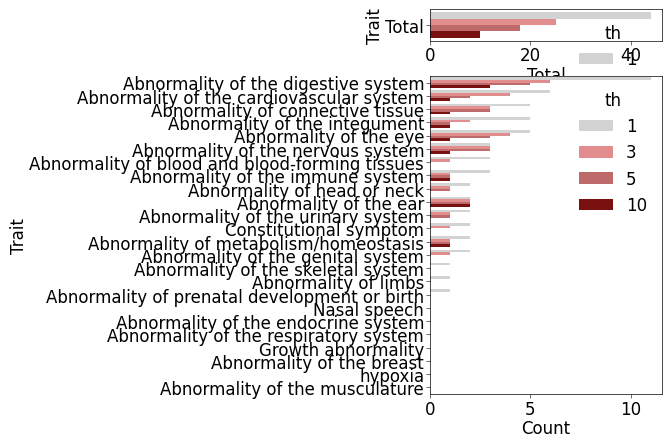

In [75]:
abnorm_df = evaluate_available_traits('Phenotypic abnormality', overlap_counts=overlap_counts,palette=['lightgrey', 'lightcoral', 'indianred', 'darkred'] )
plt.savefig(os.path.join(figdir, 'pheno_overlap_trait_counts_threshold.png'), dpi=500, bbox_inches='tight')



In [76]:
abnorm_df[abnorm_df.th == 3].to_csv(os.path.join(outdir, 'abnormality_traits_with_3_rvs.csv'), index=False)

Getting Category Counts
Getting total counts
Plotting


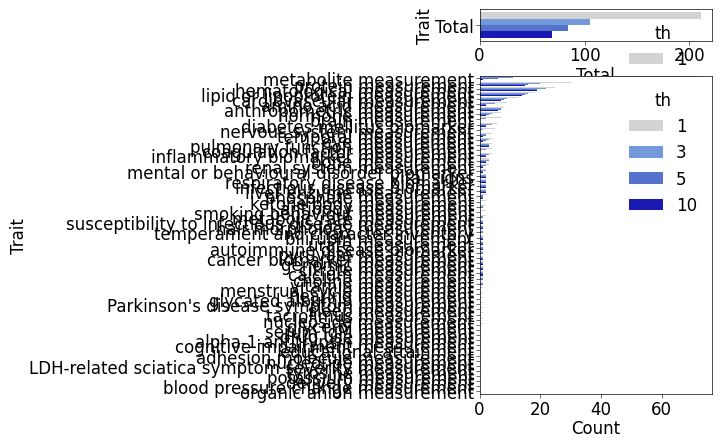

In [77]:
measure_df = evaluate_available_traits('measurement', overlap_counts=overlap_counts,palette=['lightgrey', 'cornflowerblue', 'royalblue', 'mediumblue'] )
plt.savefig(os.path.join(figdir, 'measurement_overlap_trait_counts_threshold.png'), dpi=500, bbox_inches='tight')

In [78]:
measure_df[measure_df.th == 3].to_csv(os.path.join(outdir, 'measure_traits_with_3_rvs.csv'), index=False)

In [79]:
for trait in tqdm(ravar_genes['Trait Ontology id'].unique()):
    gda = ravar_genes.loc[ravar_genes['Trait Ontology id'] == trait, ('Gene Symbol', 'Ensembl ID', 'P-value')]
    trait_out = trait.replace(':', '_')
    gda.to_csv(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/', trait_out+ '_RV.txt'), sep='\t', index=False)

100%|██████████| 1468/1468 [00:12<00:00, 118.61it/s]


In [80]:
trait_info[trait_info['Trait Ontology id'] == 'CHEBI:25722']

,Trait Ontology id,Trait Label,EFO description,EFO synonym,EFO Tree,TRAIT_CODE
577,CHEBI:25722,orotidine,NaN,NaN,orotidine|organic heterocyclic compound|chemic...,CHEBI_25722


In [81]:
ravar_genes[ravar_genes['Trait Ontology id'] == 'CHEBI:25722']

,Gene Symbol,Ensembl ID,Gene Type,CHR,Location,Reported Trait,Trait Label,Trait Ontology id,EFO synonym,P-value,TRAIT_CODE
4788,ANKRD9,ENSG00000156381,protein_coding,14,chr14:102501767-102509799,Orotidine,orotidine,CHEBI:25722,NaN,1.500000e-11,CHEBI_25722
13509,CALCOCO2,ENSG00000136436,protein_coding,17,chr17:48831018-48866522,Orotidine,orotidine,CHEBI:25722,NaN,3.600000e-10,CHEBI_25722
13584,CAMK2N1,ENSG00000162545,protein_coding,1,chr1:20482391-20486210,Orotidine,orotidine,CHEBI:25722,NaN,2.500000e-10,CHEBI_25722
14565,CCK,ENSG00000187094,protein_coding,3,chr3:42257825-42266185,Orotidine,orotidine,CHEBI:25722,NaN,1.700000e-13,CHEBI_25722
15866,CEP126,ENSG00000110318,protein_coding,11,chr11:101915010-102001062,Orotidine,orotidine,CHEBI:25722,NaN,1.700000e-11,CHEBI_25722
18382,COPA,ENSG00000122218,protein_coding,1,chr1:160288594-160343566,Orotidine,orotidine,CHEBI:25722,NaN,2.400000e-13,CHEBI_25722
19488,CXCL3,ENSG00000163734,protein_coding,4,chr4:74036589-74038807,Orotidine,orotidine,CHEBI:25722,NaN,1.900000e-11,CHEBI_25722
19489,CXCL3,ENSG00000163734,protein_coding,4,chr4:74036589-74038807,Orotidine,orotidine,CHEBI:25722,NaN,6.900000e-11,CHEBI_25722
19777,CYP2C19,ENSG00000165841,protein_coding,10,chr10:94762681-94855547,Orotidine,orotidine,CHEBI:25722,NaN,8.700000e-11,CHEBI_25722
21117,DNAI7,ENSG00000118307,protein_coding,12,chr12:25108289-25195162,Orotidine,orotidine,CHEBI:25722,NaN,5.200000e-14,CHEBI_25722
